In [ ]:
!pip install --upgrade pip
!pip install opencv-python
!pip install numpy

!pip install --upgrade numpy
!pip install h5py
!pip install Pillow

In [ ]:
import h5py
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def images_to_numpy_array_cv2_batched(image_folder, batch_size, target_size=(100, 100), color_mode='rgb', display_debug_images=1):

    print(f"Starting batch processing with target_size: {target_size}, color_mode: {color_mode}, display_debug_images: {display_debug_images}")

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')) and not f.startswith('._')]
    total_images = len(image_files)
    print(f"Found {total_images} image files (excluding files starting with ._).")

    image_list = []
    filenames_batch = []
    processed_image_count = 0

    for i, filename in enumerate(tqdm(image_files, desc="Processing images in batches")):
        img_path = os.path.join(image_folder, filename)

        try:
            if color_mode == 'grayscale':
                 img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            elif color_mode == 'rgb':
                 img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            else:
                 raise ValueError("color_mode must be 'rgb' or 'grayscale'")


            if img is not None:
                pass

                processed_img = None

                if color_mode == 'grayscale':
                    if img.ndim == 2:
                        processed_img = img
                        print(f"  Image '{filename}' already grayscale. Shape {processed_img.shape}, Ndim {processed_img.ndim}")
                    elif img.ndim == 3 and img.shape[-1] >= 3:
                        processed_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        print(f"  After BGR2GRAY Conversion '{filename}': Shape {processed_img.shape}, Ndim {processed_img.ndim}")
                    else:
                         print(f"  Warning: Skipping '{filename}' for grayscale mode due to unexpected initial shape: {img.shape}")
                         continue


                    if processed_img is not None:
                         print(f"  Grayscale Handled '{filename}': Shape {processed_img.shape}, Dtype {processed_img.dtype}, Min {np.min(processed_img)}, Max {np.max(processed_img)}")



                elif color_mode == 'rgb':
                    if img.ndim == 3 and img.shape[-1] == 3:
                        if display_debug_images > 0 and processed_image_count < display_debug_images:
                            plt.figure(figsize=(10, 5))
                            plt.subplot(1, 2, 1)
                            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                            plt.title(f"'{filename}' - Read (BGR shown as RGB)")
                            plt.axis('off')

                            processed_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                            plt.subplot(1, 2, 2)
                            plt.imshow(processed_img)
                            plt.title(f"'{filename}' - After BGR2RGB Conversion")
                            plt.axis('off')
                            plt.show()

                        else:
                            processed_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                        if display_debug_images > 0 and processed_image_count < display_debug_images:
                             processed_image_count += 1

                    elif img.ndim == 2:
                         processed_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                         print(f"  After GRAY2RGB Conversion '{filename}': Shape {processed_img.shape}, Ndim {processed_img.ndim}")
                    else:
                         print(f"  Warning: Skipping '{filename}' for RGB mode due to unexpected initial shape: {img.shape}")
                         continue



                if processed_img is not None and ((color_mode == 'grayscale' and processed_img.ndim == 2) or (color_mode == 'rgb' and processed_img.ndim == 3 and processed_img.shape[-1] == 3)):

                    img_resized = cv2.resize(processed_img, target_size)

                    if color_mode == 'grayscale':
                        img_resized = np.expand_dims(img_resized, axis=-1)
                        print(f"  After Expand Dims (Grayscale): Shape {img_resized.shape}")

                    if img_resized is not None:
                         image_list.append(img_resized)
                         filenames_batch.append(filename)
                    else:
                         print(f"  Skipping image '{filename}' due to processing error.")


                    if len(image_list) == batch_size:

                        batch_array_to_yield = np.array(image_list)


                        yield batch_array_to_yield, filenames_batch

                        image_list = []
                        filenames_batch = []

                else:
                    print(f"Warning: Image '{filename}' did not result in expected shape/channels after color handling. Final shape: {processed_img.shape if processed_img is not None else 'None'}")

            else:
                print(f"Warning: Could not read image file (None returned by imread): {filename}") # Handle files that fail to read

        except Exception as e:
            print(f"Error processing file {filename}: {e}") # Catch other potential errors

    if image_list:
        print(f"  Yielding final batch ({len(image_list)} images). Forming batch array.")
        for j, item in enumerate(image_list):
             print(f"    Item {j} shape in image_list: {item.shape}")
        batch_array_to_yield = np.array(image_list)
        print(f"  Yielding batch array: Shape {batch_array_to_yield.shape}, Dtype {batch_array_to_yield.dtype}")
        yield batch_array_to_yield, filenames_batch

In [ ]:
def save_images_to_hdf5(image_folder, output_h5_path, batch_size, target_size, color_mode):

    num_channels = 3 if color_mode == 'rgb' else 1

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')) and not f.startswith('._')]
    total_images = len(image_files)
    if total_images == 0:
         print(f"No supported image files found in {image_folder}. Skipping HDF5 save.")
         return
    else:
         print(f"Found {total_images} image files. Preparing to save to HDF5.")


    image_shape_in_h5 = (target_size[1], target_size[0], num_channels)

    output_dir = os.path.dirname(output_h5_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")


    try:
        with h5py.File(output_h5_path, 'w') as hf:

            images_dataset = hf.create_dataset(
                'images',
                shape=(total_images,) + image_shape_in_h5,
                dtype=np.uint8,
            )

            current_idx = 0
            all_filenames_list = []


            for image_batch, filename_batch in tqdm(
                images_to_numpy_array_cv2_batched(image_folder, batch_size, target_size=target_size, color_mode=color_mode),
                total=(total_images + batch_size - 1) // batch_size,
                desc="Saving batches to HDF5"
                ):


                if image_batch is not None and image_batch.shape[1:] == image_shape_in_h5 and image_batch.dtype == np.uint8:

                     batch_size_actual = image_batch.shape[0]
                     end_idx = current_idx + batch_size_actual

                     images_dataset[current_idx:end_idx] = image_batch
                     current_idx = end_idx

                     all_filenames_list.extend(filename_batch)

                else:
                     print(f"\nWarning: Skipping batch due to unexpected shape {image_batch.shape if image_batch is not None else 'None'} or dtype {image_batch.dtype if image_batch is not None else 'None'} or None batch. Expected image shape {image_shape_in_h5} and dtype uint8.")


            print("\nFinished saving image batches to HDF5.")

            filenames_filepath = output_h5_path.replace('.h5', '_filenames.txt').replace('.hdf5', '_filenames.txt')
            with open(filenames_filepath, 'w') as f:
                 for fname in all_filenames_list:
                      f.write(f"{fname}\n")
            print(f"Successfully saved all filenames to {filenames_filepath}.")

        print(f"Successfully created HDF5 file: {output_h5_path}")

    except Exception as e:
        print(f"An error occurred during HDF5 saving: {e}")

Found 3708 image files. Preparing to save to HDF5.


Saving batches to HDF5:   0%|          | 0/58 [00:00<?, ?it/s]

Starting batch processing with target_size: (1200, 1200), color_mode: rgb, display_debug_images: 1
Found 3708 image files (excluding files starting with ._).



Processing images in batches:   0%|          | 0/3708 [00:00<?, ?it/s]

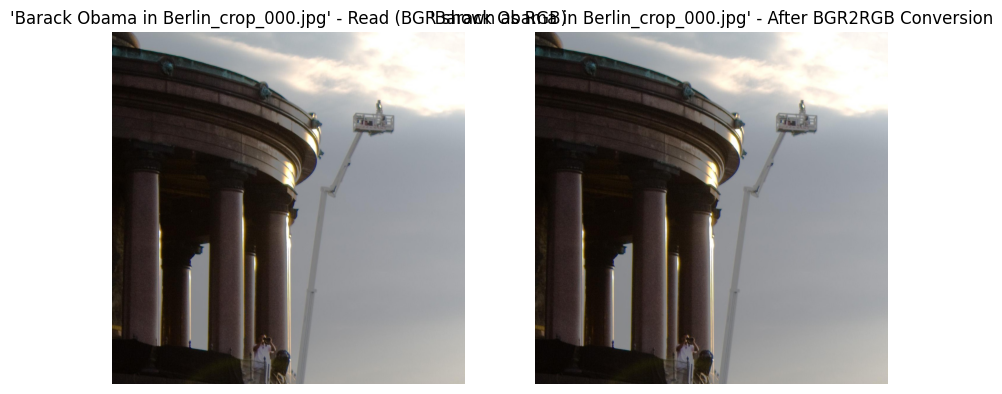


Processing images in batches: 100%|██████████| 3708/3708 [03:25<00:00, 18.08it/s]


  Yielding final batch (60 images). Forming batch array.
    Item 0 shape in image_list: (1200, 1200, 3)
    Item 1 shape in image_list: (1200, 1200, 3)
    Item 2 shape in image_list: (1200, 1200, 3)
    Item 3 shape in image_list: (1200, 1200, 3)
    Item 4 shape in image_list: (1200, 1200, 3)
    Item 5 shape in image_list: (1200, 1200, 3)
    Item 6 shape in image_list: (1200, 1200, 3)
    Item 7 shape in image_list: (1200, 1200, 3)
    Item 8 shape in image_list: (1200, 1200, 3)
    Item 9 shape in image_list: (1200, 1200, 3)
    Item 10 shape in image_list: (1200, 1200, 3)
    Item 11 shape in image_list: (1200, 1200, 3)
    Item 12 shape in image_list: (1200, 1200, 3)
    Item 13 shape in image_list: (1200, 1200, 3)
    Item 14 shape in image_list: (1200, 1200, 3)
    Item 15 shape in image_list: (1200, 1200, 3)
    Item 16 shape in image_list: (1200, 1200, 3)
    Item 17 shape in image_list: (1200, 1200, 3)
    Item 18 shape in image_list: (1200, 1200, 3)
    Item 19 shape in i

Saving batches to HDF5: 100%|██████████| 58/58 [03:26<00:00,  3.56s/it]



Finished saving image batches to HDF5.
Successfully saved all filenames to /Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/cropped_real_1200x1200_filenames.txt.
Successfully created HDF5 file: /Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/cropped_real_1200x1200.h5
Found 920 image files. Preparing to save to HDF5.


Saving batches to HDF5:   0%|          | 0/15 [00:00<?, ?it/s]

Starting batch processing with target_size: (1200, 1200), color_mode: rgb, display_debug_images: 1
Found 920 image files (excluding files starting with ._).



Processing images in batches:   0%|          | 0/920 [00:00<?, ?it/s]

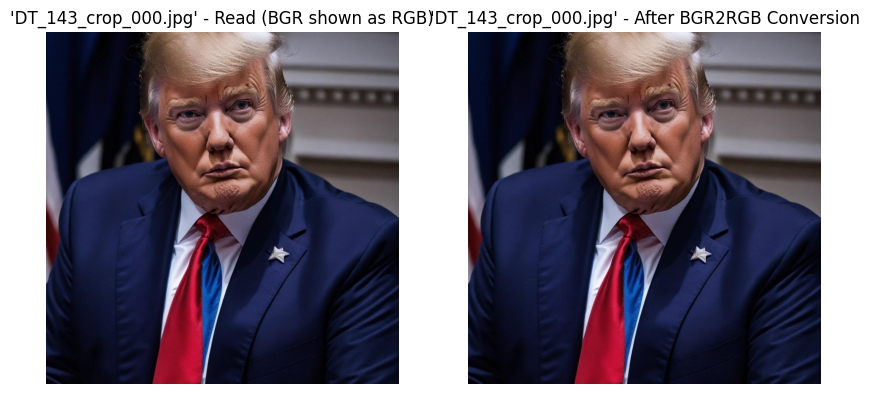


Processing images in batches: 100%|██████████| 920/920 [00:59<00:00, 15.38it/s]


  Yielding final batch (24 images). Forming batch array.
    Item 0 shape in image_list: (1200, 1200, 3)
    Item 1 shape in image_list: (1200, 1200, 3)
    Item 2 shape in image_list: (1200, 1200, 3)
    Item 3 shape in image_list: (1200, 1200, 3)
    Item 4 shape in image_list: (1200, 1200, 3)
    Item 5 shape in image_list: (1200, 1200, 3)
    Item 6 shape in image_list: (1200, 1200, 3)
    Item 7 shape in image_list: (1200, 1200, 3)
    Item 8 shape in image_list: (1200, 1200, 3)
    Item 9 shape in image_list: (1200, 1200, 3)
    Item 10 shape in image_list: (1200, 1200, 3)
    Item 11 shape in image_list: (1200, 1200, 3)
    Item 12 shape in image_list: (1200, 1200, 3)
    Item 13 shape in image_list: (1200, 1200, 3)
    Item 14 shape in image_list: (1200, 1200, 3)
    Item 15 shape in image_list: (1200, 1200, 3)
    Item 16 shape in image_list: (1200, 1200, 3)
    Item 17 shape in image_list: (1200, 1200, 3)
    Item 18 shape in image_list: (1200, 1200, 3)
    Item 19 shape in i

Saving batches to HDF5: 100%|██████████| 15/15 [01:00<00:00,  4.00s/it]



Finished saving image batches to HDF5.
Successfully saved all filenames to /Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/cropped_synthetic_1200x1200_filenames.txt.
Successfully created HDF5 file: /Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/cropped_synthetic_1200x1200.h5


In [34]:

save_images_to_hdf5('/Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/real',
                    '/Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/cropped_real_1200x1200.h5', 64, (1200, 1200), 'rgb')
#
save_images_to_hdf5('/Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/synthetic',
                    '/Volumes/T7/drive_thesis/thesis/img/cropped/1200/n_3/cropped_synthetic_1200x1200.h5', 64, (1200, 1200), 'rgb')